# Assignment #4 - Object Detection & Localization
Cell Images for Detecting Malaria

In [2]:
from PIL import Image

import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2


#### Define Helpers

In [3]:
def seed_everything(val):
    random.seed(val)
    os.environ['PYTHONHASHSEED'] = str(val)
    np.random.seed(val)
    torch.manual_seed(val)
    torch.cuda.manual_seed(val)
    torch.cuda.manual_seed_all(val)
    torch.backends.cudnn.deterministic = True
    print('Manual seed changed successfully.')

seed = 42
seed_everything(seed)

Manual seed changed successfully.


In [4]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(40, 40))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(40)

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [5]:
def bbox_plot(img, bb1, bb2):
    imn = np.array(img.data.cpu().detach().numpy()).reshape(3, 256, 256).transpose(1, 2, 0)
    bb1 = bb1.cpu().detach().numpy()
    bb2 = bb2.cpu().detach().numpy()
    fig, ax = plt.subplots()
    ax.imshow((imn -np.min(imn) )*1/(np.max(imn)-np.min(imn)))
    bbox1 = patches.Rectangle((bb1[0], bb1[1]), bb1[2], bb1[3], linewidth=1, edgecolor='r', facecolor='none')
    bbox2 = patches.Rectangle((bb2[0], bb2[1]), bb2[2], bb2[3], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(bbox1)
    ax.add_patch(bbox2)
    plt.show()
    return fig

### Image Placement on Canvas
The function generates random coordinates, creates a new black canvas, and pastes the image onto it.


In [6]:
def resize_canvas(img, canvas_dim=256):
    w, h = img.size
    assert w < canvas_dim and h < canvas_dim
    x , y = random.randrange(canvas_dim - w),random.randrange(canvas_dim - h)

    mode = img.mode
    if len(mode) == 1:  # L, 1
        new_background = (0)
    if len(mode) == 3:  # RGB
        new_background = (0, 0, 0)
    if len(mode) == 4:  # RGBA, CMYK
        new_background = (0, 0, 0, 0)

    new_img = Image.new(mode, (canvas_dim, canvas_dim), new_background)
    new_img.paste(img, (x , y ))
    return (x, y, w, h), new_img

### Intersection over Union (IoU) Calculation
The function converts the input coordinates to (X, Y, X2, Y2), calculates the coordinates of the intersection box, computes the area of overlap, and finally calculates the IoU score. The result is a value between 0 and 1, where 0 indicates no overlap, and 1 indicates perfect overlap.


In [7]:
def get_iou(a, b, epsilon=1e-5):
    a[2] = a[0] + a[2]
    a[3] = a[1] + a[3]
    b[2] = b[0] + b[2]
    b[3] = b[1] + b[3]

    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    width = (x2 - x1)
    height = (y2 - y1)

    if (width < 0) or (height < 0):
        return 0.0

    area_overlap = width * height

    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    iou = area_overlap / (area_combined+epsilon)

    return iou

This image transform should stretch the image by a uniformly distributed random factor whose range is given in the constructor (stretch_region) as a tuple of (low, high).


In [8]:
class RandomStretch:
    def __init__(self, stretch_region):
        assert 0.5 < stretch_region[0] < stretch_region[1] < 10
        self.stretch_region = stretch_region

    def __call__(self, im):
        factor = random.uniform(self.stretch_region[0],self.stretch_region[1])
        w, h = im.size
        new_size = (int(w * factor),int(h * factor))
        resized_im = im.resize((new_size))
        return resized_im

Stretches the given image by some factor, places it on a black canvas of a given size in a random location.

In [9]:
class StretchLocAndRemember:
    def __init__(self, stretch_region=(0.6, 1)):
        self.random_stretch = RandomStretch(stretch_region)
        self.loc = {}

    def __call__(self, inp):
        if isinstance(inp, Image.Image):
            stretched_img = self.random_stretch(inp)
            self.loc, new_image = resize_canvas(stretched_img)

            return new_image

        return torch.Tensor(self.loc), inp

##### Example to using the augmentation

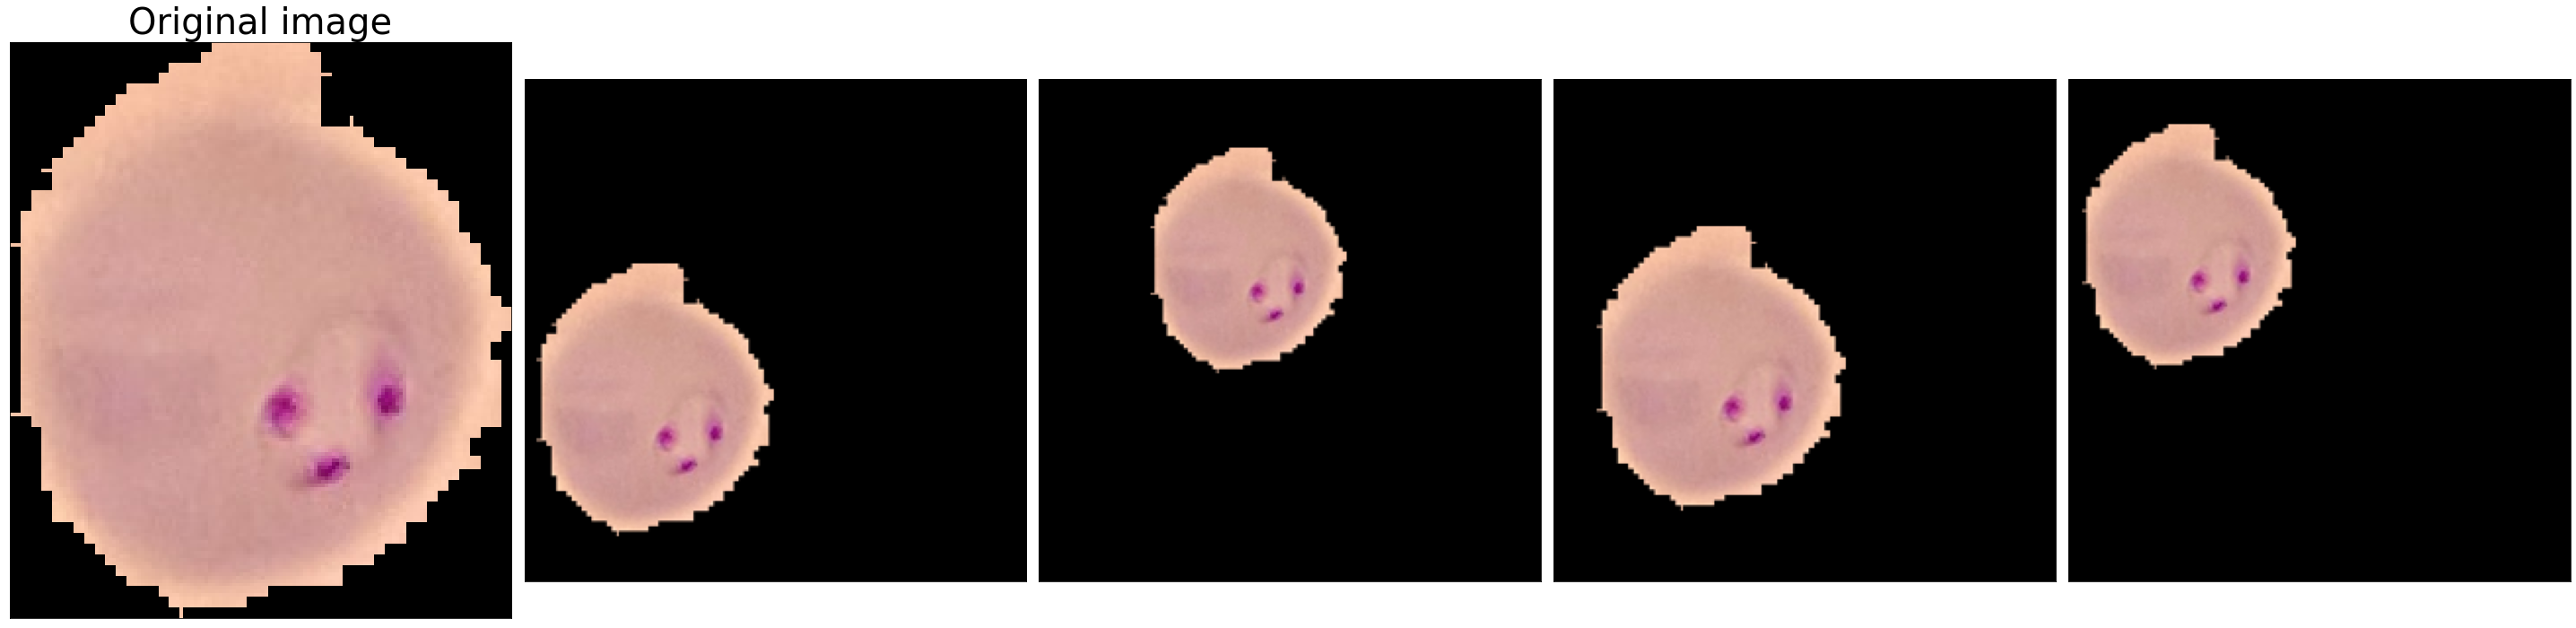

In [10]:
data_path = '../Datasets/cell_images'
orig_img = Image.open(os.path.join(data_path, "Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png"))
rand_localized = [StretchLocAndRemember()(orig_img) for _ in range(4)]
plot(rand_localized)

#### Loading Data Functions
Returns the transforms which will be applied to the data and the target. slar is a StretcLochAndRemember transform we have implemented in order to stretch an image and save its location. The saved location is used as the bounding box ground truth we are learning. That's why its object is common in both the images and target transformations.

In [11]:
def get_transforms():
    slar = StretchLocAndRemember() 

    common_transforms = transforms.Compose([
                    transforms.Resize([140, 140]),
                    slar,
                    transforms.ToTensor(),
                ])

    target_transforms = transforms.Compose([
                    slar,
                ])

    return common_transforms, target_transforms

def load_data(batch_size):
    common_transforms, target_transforms = get_transforms()
    train_set = ImageFolder(root=data_path, transform=common_transforms, target_transform=target_transforms)
    val_set_size = int(0.2 * len(train_set))
    trainset, valset = random_split(train_set, [len(train_set) - val_set_size, val_set_size])

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

##### Exploring one batch

In [12]:
train_loader, val_loader = load_data(batch_size=3)
data, target = next(iter(val_loader), [0])
print("bbox [x,y,w,h] are", target[0], "\nlabels are", target[1])

bbox [x,y,w,h] are tensor([[129., 154.,  96.,  96.],
        [ 50., 166.,  85.,  85.],
        [107.,  56., 123., 123.]]) 
labels are tensor([0, 1, 1])


#### Model Definition

In [13]:
class CellNet(nn.Module):
    def __init__(self):
        super(CellNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2)

        self.fc1 = nn.Linear(576, 512)
        self.fc2 = nn.Linear(512,2)
        self.fc1_loc = nn.Linear(576,64)
        self.fc2_loc = nn.Linear(64,4) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))

        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 4)

        x = torch.flatten(x, 1)
        loc = F.relu(self.fc1_loc(x))
        loc = self.fc2_loc(loc)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x, loc

In [14]:
writer = SummaryWriter('runs')


### Train Model
##### Training Function
The `train` function conducts model training using classification and localization losses, optimizing with a specified optimizer. It iterates through batches, updates parameters, logs progress, and writes to TensorBoard.

##### Evaluation Function
The `eval` function assesses the model's accuracy and Intersection over Union (IoU) on the validation set. It accumulates correct predictions and IoU scores, then prints and displays the accuracy and IoU results.


In [15]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()

    classifier_loss = nn.CrossEntropyLoss()
    localization_loss = nn.MSELoss()


    for batch_idx, (data, target) in enumerate(train_loader):
        location, label = target
        data, location, label = data.to(device), location.to(device), label.to(device)

        optimizer.zero_grad()

        prediction, bbox = model(data)
        loss = (1 - losses_ratio) * classifier_loss(prediction,label) + losses_ratio * localization_loss(bbox,location)

        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train set, Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.data:.6f}')

            writer.add_scalar('loss value', loss)
            correct_class = 0
            pred = torch.argmax(prediction.data, axis=1)
            correct_class += torch.eq(pred, label).sum()
            accuracy = correct_class*100/len(train_loader.dataset)
            writer.add_scalar('accuracy', accuracy,global_step = batch_idx)
            writer.add_figure('bbox plot',bbox_plot(data[0],bbox[0],location[0]),global_step=batch_idx)


def eval(model, epoch, val_loader):
    model.eval()

    correct, ious = 0, 0

    with torch.no_grad():
        for data, target in val_loader:
            location, label = target
            data, location, label = data.to(device), location.to(device), label.to(device)

            prediction, bbox = model(data)
            pred = torch.argmax(prediction.data, axis=1)

            correct += torch.eq(pred, label).sum()

            for i in range(len(bbox)):
                ious += get_iou(location.data[i], bbox.data[i])

        ious /= 0.01 * len(val_loader.dataset)
        print(f'\nValidation set, Epoch {epoch}, Accuracy: {correct}/{len(val_loader.dataset)}'
              f' ({100. * correct / len(val_loader.dataset):.0f}%), '
              f'IOUS {ious}\n')

Start training

Working on device: cpu
Train set, Epoch 1 [0/22047 (0%)]	Loss: 1.262464


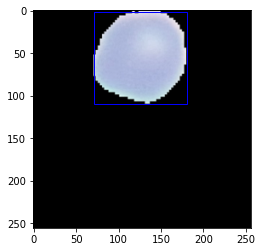

Train set, Epoch 1 [6400/22047 (29%)]	Loss: 0.845834


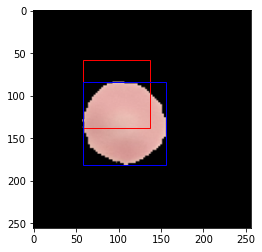

Train set, Epoch 1 [12800/22047 (58%)]	Loss: 0.750600


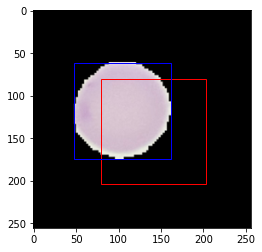

Train set, Epoch 1 [19200/22047 (87%)]	Loss: 0.745710


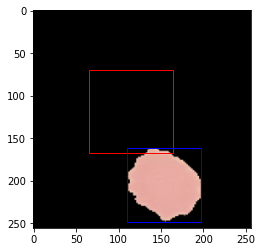


Validation set, Epoch 1, Accuracy: 2910/5511 (53%), IOUS 49.42287063598633

Train set, Epoch 2 [0/22047 (0%)]	Loss: 0.726425


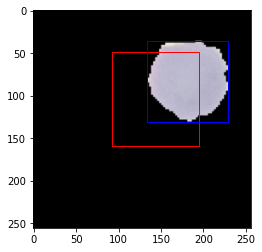

Train set, Epoch 2 [6400/22047 (29%)]	Loss: 0.707173


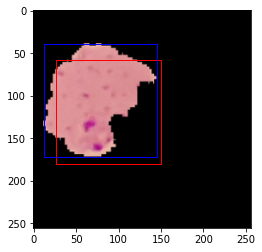

Train set, Epoch 2 [12800/22047 (58%)]	Loss: 0.711137


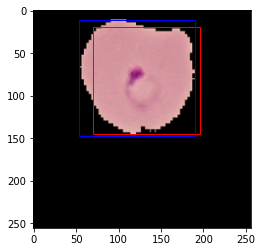

Train set, Epoch 2 [19200/22047 (87%)]	Loss: 0.700556


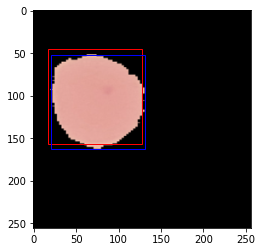


Validation set, Epoch 2, Accuracy: 2931/5511 (53%), IOUS 65.43335723876953

Train set, Epoch 3 [0/22047 (0%)]	Loss: 0.703759


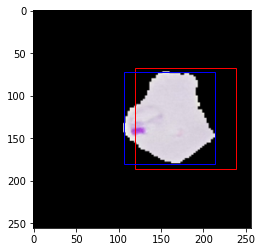

Train set, Epoch 3 [6400/22047 (29%)]	Loss: 0.655237


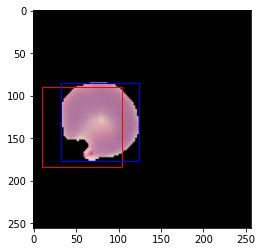

Train set, Epoch 3 [12800/22047 (58%)]	Loss: 0.635837


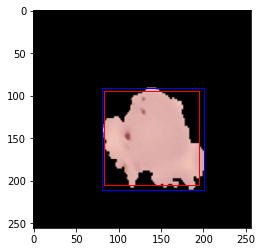

Train set, Epoch 3 [19200/22047 (87%)]	Loss: 0.439626


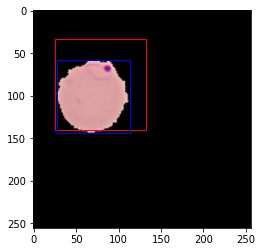


Validation set, Epoch 3, Accuracy: 4909/5511 (89%), IOUS 58.31559753417969

Train set, Epoch 4 [0/22047 (0%)]	Loss: 0.331397


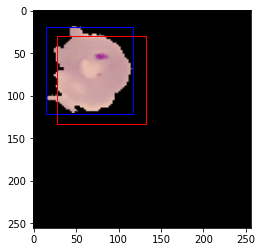

Train set, Epoch 4 [6400/22047 (29%)]	Loss: 0.269049


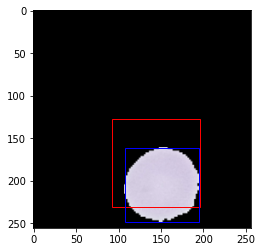

Train set, Epoch 4 [12800/22047 (58%)]	Loss: 0.318918


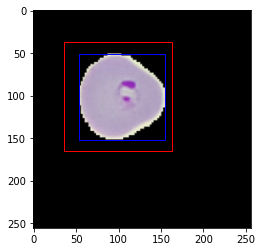

Train set, Epoch 4 [19200/22047 (87%)]	Loss: 0.196740


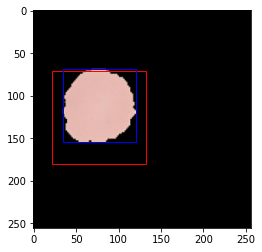


Validation set, Epoch 4, Accuracy: 4938/5511 (90%), IOUS 64.24893188476562

Train set, Epoch 5 [0/22047 (0%)]	Loss: 0.216458


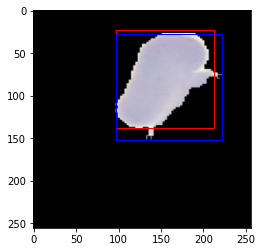

Train set, Epoch 5 [6400/22047 (29%)]	Loss: 0.239730


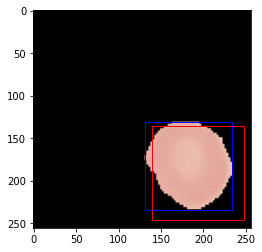

Train set, Epoch 5 [12800/22047 (58%)]	Loss: 0.193968


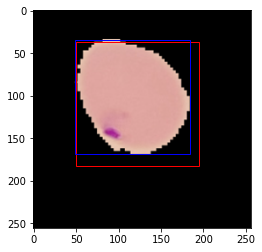

Train set, Epoch 5 [19200/22047 (87%)]	Loss: 0.251674


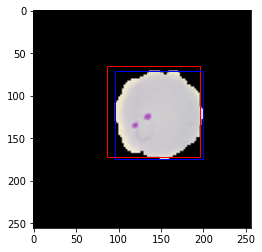


Validation set, Epoch 5, Accuracy: 5083/5511 (92%), IOUS 65.92083740234375

Done training!


In [16]:
lr = 0.001
losses_ratio = 0.00006
epochs = 5
log_interval = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on device: {device}')

model = CellNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

batch_size = 128
train_loader, val_loader = load_data(batch_size)

for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader, log_interval)
    eval(model, epoch, val_loader)

print('Done training!')

Saving Trained Model


In [17]:
save_path = 'trained_locator.pt'
torch.save(model.state_dict(), save_path)

In [18]:
new_model = CellNet()
new_model.load_state_dict(torch.load(save_path))

# make model ready to inference
new_model.eval()

CellNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (fc1_loc): Linear(in_features=576, out_features=64, bias=True)
  (fc2_loc): Linear(in_features=64, out_features=4, bias=True)
)

#### Evaluate Predicted Bounding Box

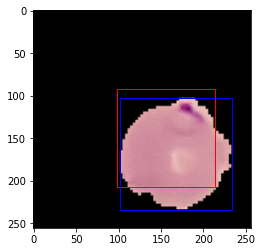

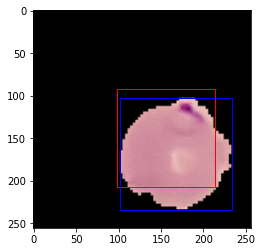

In [19]:
""" Explore one predicted bounding box """
data, (location, label) = next(iter(train_loader), [0])
data, location, label = data.to(device), location.to(device), label.to(device)
_, bbox = model(data)
bbox_plot(data[0], bbox[0], location[0])

#### Inference

In [20]:
def test(test_loader, new_model):
    correct, ious = 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            location, label = target
            data, location, label = data.to(device), location.to(device), label.to(device)

            prediction, bbox = new_model(data)

            pred = torch.argmax(prediction.data, axis=1)

            correct += torch.eq(pred, label).sum()

            for i in range(len(bbox)):
                ious += get_iou(location.data[i], bbox.data[i])

        ious /= 0.01 * len(test_loader.dataset)
        print(f'\nValidation set, Epoch {epoch}, Accuracy: {correct}/{len(test_loader.dataset)}'
              f' ({100. * correct / len(test_loader.dataset):.0f}%), '
              f'IOUS {ious}\n')

In [21]:
test(val_loader,new_model)



Validation set, Epoch 5, Accuracy: 5069/5511 (92%), IOUS 66.03144073486328

